<a href="https://colab.research.google.com/github/Akasxh/Deepfake_Detection/blob/main/DeepFake_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
birdy654_cifake_real_and_ai_generated_synthetic_images_path = kagglehub.dataset_download('birdy654/cifake-real-and-ai-generated-synthetic-images')

print('Data source import complete.')


In [ ]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [ ]:
# Check if GPUs are available for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# 1. Data Acquisition and Preprocessing
image_size = (128, 128)
data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'  # Update with your dataset path

In [ ]:
def load_data(data_dir, max_images=1000):
    images = []
    labels = []
    for label in ["REAL", "FAKE"]:  # Assuming subfolders 'REAL' and 'FAKE' exist
        path = os.path.join(data_dir, label)
        count = 0
        for img_file in os.listdir(path):
            if count >= max_images // 2:  # Load only half of max_images per class
                break
            img_path = os.path.join(path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(0 if label == "REAL" else 1)
                count += 1
    return np.array(images), np.array(labels)

images, labels = load_data(data_dir)
images = images / 255.0  # Normalize images

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print data summary
print(f"Number of training samples: {len(X_train)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 800
Number of test samples: 200


In [ ]:
# 2. Building the CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

model = Sequential([
    Input(shape=(image_size[0], image_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
# 3. Training the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
20/20 [==============================] - 0s 20ms/step - loss: 0.3231 - accuracy: 0.8500 - val_loss: 0.6279 - val_accuracy: 0.7250
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.3182 - accuracy: 0.8641 - val_loss: 0.6405 - val_accuracy: 0.7250
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 0.2827 - accuracy: 0.8719 - val_loss: 0.6292 - val_accuracy: 0.7563
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.2480 - accuracy: 0.9047 - val_loss: 0.7107 - val_accuracy: 0.7500
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 0.1855 - accuracy: 0.9453 - val_loss: 0.7802 - val_accuracy: 0.7500
Epoch 6/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1636 - accuracy: 0.9344 - val_loss: 0.7558 - val_accuracy: 0.7625
Epoch 7/100
20/20 [==============================] - 0s 14ms/step - loss: 0.1354 - accuracy: 0.9609 - val_loss: 0.9722 - val_accuracy: 0.7000
Epoch 

In [ ]:
# 4. Evaluating Model Performance
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        96
           1       0.71      0.75      0.73       104

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.71      0.71       200



In [ ]:
# 5. Implementing GradCAM for Model Interpretability
def generate_gradcam(model, image, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[1:3], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[0, :, :, i]

    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cam / np.max(cam)  # Normalize between 0 and 1
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    return cam

def display_gradcam(image, cam, alpha=0.4):
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.show()

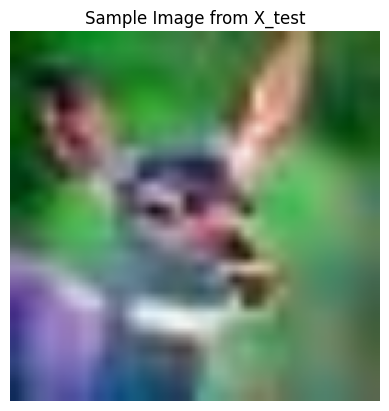

In [ ]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(X_test[0])  # Assumes images are in RGB format
plt.axis('off')  # Optional: Turn off axis
plt.title('Sample Image from X_test')
plt.show()


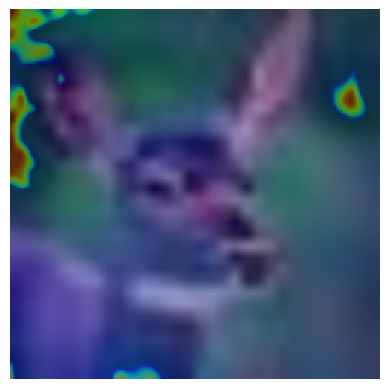

In [ ]:
# Select a test image to visualize GradCAM
sample_image = X_test[0]
cam = generate_gradcam(model, sample_image, layer_name='conv2d_3')  # Adjust layer_name as per your model
display_gradcam(sample_image, cam)

7/7 [==============================] - 0s 4ms/step


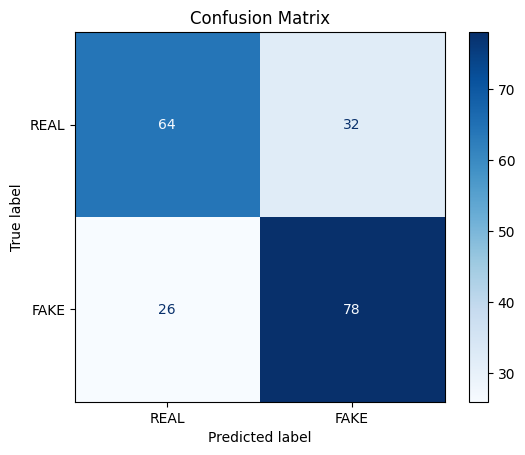

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate predictions (rounded for binary classification)
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
